# A. Initial Analysis

To get an idea if our proposal is feasible or not, we performed some elementary analysis.

In [1]:
import pandas as pd

import spacy

nlp = spacy.load('en_core_web_sm')

In [2]:
df = pd.read_csv(
    '../data/raw/plot_summaries.txt', 
    sep='\t', 
    header=None, 
    names=['wikipedia_movie_id', 'summary']
)

In [14]:
death_terms = [
    'die', 'dies', 'died', 'dying',
    'kill', 'kills', 'killed', 'killing',
    'murder', 'murders', 'murdered', 'murdering',
    'assassinate', 'assassinates', 'assassinated', 'assassinating',
    'perish', 'perishes', 'perished', 'perishing',
    'execute', 'executes', 'executed', 'executing',
    'slaughter', 'slaughters', 'slaughtered', 'slaughtering',
    'slay', 'slays', 'slew', 'slain', 'slaying',
    'poison', 'poisons', 'poisoned', 'poisoning',
    'drown', 'drowns', 'drowned', 'drowning',
    'hang', 'hangs', 'hanged', 'hanging',
    'decapitate', 'decapitates', 'decapitated', 'decapitating',
    'sacrifice', 'sacrifices', 'sacrificed', 'sacrificing',
    'death', 'demise', 'fatality', 'casualty', 'massacre',
    'decease', 'grave', 'suicide', 'extinct', 'martyr',
    'annihilated', 'decimated', 'obliterated', 'devastated',
    'overkill', 'euthanatized', 'extinguished', 'overdosed',
    'deathbed', 'mortal', 'posthumous', 'postmortem', 'rigor mortis',
    'snuffed', 'suffocate', 'perish', 'corpse', 'coroner', 'cadaver',
    
]

death_phrases = [
    'pass away', 'passes away', 'passed away', 'passing away',
    'lose his life', 'lose her life', 'lost his life', 'lost her life',
    'meet their end', 'meets their end', 'met their end',
    'breathe his last', 'breathe her last', 'breathed his last', 'breathed her last',
    'take his life', 'take her life', 'took his life', 'took her life',
    'put down', 'moved down', 'six feet under', 'bleed out', 'bled out', 'met their end',
    'meet their end', 'met his end', 'met her end', 'meet his end', 'meet her end',
    'met their maker', 'met his maker', 'met her maker', 'meet their maker', 
    'meet his maker', 'meet her maker', 'not long for this world', 'not long for this life',
    'pay the ultimate price', 'payed the ultimate price', 'paying the ultimate price',
    'taken out', 'took out', 
]

In [15]:
from spacy.matcher import PhraseMatcher

phrase_matcher = PhraseMatcher(nlp.vocab)
death_phrase_patterns = [nlp.make_doc(text) for text in death_phrases]
phrase_matcher.add('DEATH_PHRASES', None, *death_phrase_patterns)

In [16]:
def contains_death_terms(text):
    doc = nlp(text)
    death_found = False

    # Check for death-related lemmas
    for token in doc:
        if token.lemma_.lower() in death_terms:
            # Check for negations (e.g., "did not die")
            if not any(child.dep_ == 'neg' for child in token.children):
                death_found = True
                break

    # Check for death-related phrases
    matches = phrase_matcher(doc)
    if matches:
        for match_id, start, end in matches:
            span = doc[start:end]
            # Check for negations in phrases
            if not any(token.dep_ == 'neg' for token in span.root.children):
                death_found = True
                break

    return death_found

In [17]:
df['contains_death'] = df['summary'].apply(contains_death_terms)

df.head()

wikipedia_movie_id                                            summary  \
0            23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1            31186339  The nation of Panem consists of a wealthy Capi...   
2            20663735  Poovalli Induchoodan  is sentenced for six yea...   
3             2231378  The Lemon Drop Kid , a New York City swindler,...   
4              595909  Seventh-day Adventist Church pastor Michael Ch...   

   contains_death  
0           False  
1            True  
2            True  
3           False  
4            True

In [18]:
df['contains_death'].value_counts()

contains_death
True     21452
False    20851
Name: count, dtype: int64

### Many summaries include links and other tags:

```
<ref namehttp://www.mtv.com/news/articles/1596736/20081009/spears_britney.jhtml|titleVena|first2008-09-08|publisher2008-09-10}}{{cite news}}` 
```
```
<ref name Die Like a Dog, A lauded Mongolian film probes a mongrel's soul | publisher  http://www.time.com/time/asia/asia/magazine/1999/990125/mongolia_dog1.html}}
```
```
<ref namehttp://movies.nytimes.com/movie/226202/Waldo's-Last-Stand/overview |title2008-10-08|work=NY Times}}
```
```
<ref namehttp://www.onf-nfb.gc.ca/eng/collection/film/?idSkin Deep|work9 June 2009}}<ref name0111211|title=Skin Deep}}
```
```
{{Plot|date"Farewell My Concubine Study Notes">{{cite web}}
```

**Notice that some of the tags are mismatched `<ref ...}}` or unclosed `{{..`.**


### Some summaries are cast lists:

Cast  *Violent J&nbsp;– J *Shaggy 2 Dope&nbsp;– Shaggy *Krista Kalmus&nbsp;– Amy *Lindsay Ballew&nbsp;– Stacy *Kathlyne Pham&nbsp;– Tiffany *Damian Lea&nbsp;– Brad *Sabin Rich&nbsp;– Carl *Mark Jury&nbsp;– Guy In Car *Roxxi Dolt&nbsp;– Girl In Car
--&#62;  *Peter Haber as Martin Beck *Mikael Persbrandt as Gunvald Larsson *Stina Rautelin as Lena Klingström *Per Morberg as Joakim Wersén *Rebecka Hemse as Inger  *Michael Nyqvist as John Banck *Anna Ulrica Ericsson as Yvonne Jäder *Peter Hüttner as Oljelund *Lennart Hjulström as Gavling *Lasse Lindroth as Peter

### Some summaries are reviews:

An attempt to bring the famed "Mr. Bill" clay characters to "life" in a sitcom format, this Showtime special featured Mr. Bill , his wife  and son , as well as his next-door neighbor, Sluggo ([[Michael McManus , his wife  and daughter . Although starring actors, the "Bills" were shown to be a "miniature" family, with many of the jokes revolving around the characters' small size and the challenges they faced living in a "large" human world, as well as scenarios where Mr. Bill is subjected to the various abusive situations the original Saturday Night Live character was best known for. Although the audience was invited to "look out for more shows" at the end of the 43-minute special, no follow-up "Mr. Bill" shows were ever produced.


### Some valid summaries have special characters:

Alan Colby, heir to a vast fortune, reappears after a seven year absence, only to be murdered before he can claim his inheritance. The Lowells have been living off the Colby fortune, and now someone is trying to kill Henrietta Lowell, matriarch of the family. Among the suspects are: *Fred and Janice Gage, who live off the Lowell  fortune, which would have gone to Alan Colby, the murdered man *Prof. Bowen, who is paid handsomely by the Lowells for his valuable psychic research *Mr. Phelps, the executor of the Lowell estate *Ulrich, who had a longstanding grudge against Alan Colby *Henrietta Lowell, who wants to continue psychic research

# B. Death Classification with Bags-of-Words

### Bags-of-Words matching
We preprocess the movie summaries we have into character's bag of words. For each character, we simply check whether:
- The character's Agent Verbs contain: died, perished, ... OR
- The character's Patient Verbs contain: killed, assassinated, ...   

In [2]:
import numpy as np
import json
import os
import pandas as pd

from pathlib import Path

from src.character_deaths.bags_analysis import count_character_deaths

In [3]:
data_path = Path('data/processed')

records = {}

for movie in os.listdir(data_path):
    character_bags = json.load(open(data_path / movie))
    movie_id = movie.split('_')[-1].split('.')[0]
    num_deaths, character_deaths =  count_character_deaths(character_bags)
    records[movie_id] = {'num_deaths': num_deaths,
                         'num_characters': len(character_bags),
                         'character_deaths': character_deaths}

In [4]:
print(f'Number of movies = {len(records)}')
print(f'Number of characters = {np.sum([v['num_characters'] for k, v in records.items()])}')
print(f'Number of deaths = {np.sum([v['num_deaths'] for k, v in records.items()])}\n')

print(f'Average number of characters per movie = {np.mean([v['num_characters'] for k, v in records.items()]).round(2)}')
print(f'Average number of deaths per movie = {np.mean([v['num_deaths'] for k, v in records.items()]).round(2)}')
print(f'Average percentage of dead characters = {np.mean([v['num_deaths'] / v['num_characters'] for k, v in records.items()]).round(2)}')

Number of movies = 18990
Number of characters = 57949
Number of deaths = 7232

Average number of characters per movie = 3.05
Average number of deaths per movie = 0.38
Average percentage of dead characters = 0.11


This method is incapable of accounting for language nuances:
- One summary contained the following "Two-Face then attacks the party and nearly kills Batman".
- Batman is considered dead since the model can not differentiate between "nearly kills" and "kills".

We decided to abandon this method due to lack of reliability.

# C. DPM Trope Clustering

### Dirichlet Persona Model:
The model used here to cluster the characters by trope is described in the paper: </br> Bamman, D., O’Connor, B., & Smith, N. A. (2013). Learning latent personas of film characters. Proceedings of the 51st Annual Meeting of the Association for Computational Linguistics (ACL), 352–361.

### How it works:
Each character has a bag of words extracted from movie summaries. These bag of words contain attributes and agent and patient verbs, which are actions either the character took or were taken on the character. </br>
Using these bag of words, we can create a document-term matrix (here if the same verb is once patient and once agent, it is considered as 2 different features). </br>
Using the document-term matrix, the model associates each character with a latent persona.

In [2]:
bags_folder = os.path.abspath('data/char_bags') #Bag of words json file from build_char_word_bags.py output
tropes_file = os.path.abspath('data/tropes/tvtropes.clusters.txt') #tropes from CMU dataset

In [3]:
from src.trope_clustering.DPM_utilities import load_character_bags

#load character bags of words
char_full = load_character_bags(bags_folder)

In [4]:
from src.trope_clustering.DPM_utilities import get_dt_matrix

dt_matrix, agent_features, patient_features, attribute_features = get_dt_matrix(char_full)
combined_features = list(agent_features) + list(patient_features) + list(attribute_features)

print("Number of agent features:", len(agent_features))
print("Number of patient features:", len(patient_features))
print("Number of attribute features:", len(attribute_features))
print("Document-term matrix shape:\n", dt_matrix.shape)

Number of agent features: 9291
Number of patient features: 8627
Number of attribute features: 16799
Document-term matrix shape:
 (41529, 34717)


In [5]:
from src.trope_clustering.DPM_utilities import load_tropes

#load character tropes
tropes = load_tropes(tropes_file)
print(f"Sample size: {len(tropes)}")
print(f"Number of unique tropes: {len(set(tropes.values()))}")

Sample size: 434
Number of unique tropes: 72


In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=len(set(tropes.values()))) 
persona_distributions = lda.fit_transform(dt_matrix)

In [7]:
print("Top 5 words for the first 5 personas:")

for idx, topic in enumerate(lda.components_):
    if idx > 4:
        break
    top_indices = topic.argsort()[-5:][::-1]
    print(f"Persona {idx}: {[combined_features[i] for i in top_indices]}")

Top 5 words for the first 5 personas:
Persona 0: ['transform', 'take', 'identify', 'meet', 'defeat']
Persona 1: ['attract', 'try', 'family', 'marry', 'have']
Persona 2: ['befriend', 'child', 'richard', 'susan', 'kill']
Persona 3: ['receive', 'assistant', 'van', 'tell', 'get']
Persona 4: ['love', 'tell', 'leave', 'marry', 'be']


In [8]:
from src.trope_clustering.DPM_utilities import get_overlapping_characters

#update the characaters and tropes to only include ones whose trope we know and who we have the bag of words for (ie. characters included in both the bag of words dataset we have and in the trope testing set)
char_filtered, tropes_filtered = get_overlapping_characters(char_full, tropes)

print(f"Sample size of overlapping chars: {len(tropes_filtered)}")

Sample size of overlapping chars: 131


In [9]:
from src.trope_clustering.DPM_utilities import get_clusters_dictionary
cluster_dict = get_clusters_dictionary(char_full, char_filtered, persona_distributions.argmax(axis=1), len(set(tropes.values())))

from src.trope_clustering.DPM_utilities import get_tropes_dictionary
grouped_by_trope = get_tropes_dictionary(tropes_filtered)

In [10]:
char_of_interest = ["Darth Vader", "Hannibal Lecter", "Anakin Skywalker", "Agent Smith", "Nancy Thompson"]
for char in char_of_interest:
    print(f"{char}:\n")
    print(f"Prediction cluster containing {char} (Only showing characters who exist in tvtropes.clusters.txt):")
    for cluster, characters in cluster_dict.items():
        if char in characters: print(f"Cluster {cluster}: {', '.join(characters)}")
    print(f"\nGroundtruth cluster containing {char} (Only showing characters who exist in tvtropes.clusters.txt):")
    for trope, characters in grouped_by_trope.items():
        if char in characters: print(f"{trope}: {', '.join(characters)}")
    print("\n=====================\n")

Darth Vader:

Prediction cluster containing Darth Vader (Only showing characters who exist in tvtropes.clusters.txt):
Cluster 60: Riley Poole, Darth Vader

Groundtruth cluster containing Darth Vader (Only showing characters who exist in tvtropes.clusters.txt):
master_swordsman: Obi-Wan Kenobi, Bill, Aragorn, Blade, Darth Vader


Hannibal Lecter:

Prediction cluster containing Hannibal Lecter (Only showing characters who exist in tvtropes.clusters.txt):
Cluster 59: Gaston, Hannibal Lecter, The Chief

Groundtruth cluster containing Hannibal Lecter (Only showing characters who exist in tvtropes.clusters.txt):
cultured_badass: Hannibal Lecter, Dorian Gray


Anakin Skywalker:

Prediction cluster containing Anakin Skywalker (Only showing characters who exist in tvtropes.clusters.txt):
Cluster 19: Anakin Skywalker, Mia Thermopolis

Groundtruth cluster containing Anakin Skywalker (Only showing characters who exist in tvtropes.clusters.txt):
gadgeteer_genius: Lucius Fox, Lewis, Anakin Skywalker

### Initial concerns:
Before implementing this method, the concern was mainly the need to specify the number of clusters, and the need to manually assign a trope to each cluster. Here we attempt to simplify that by using the tvtropes.clusters.txt dataset. We could match the predicted clusters to the dataset tropes if they have a big enough intersection. Therefore we also set the number of cluster to the number of tropes in the dataset. </br>
Another concern is the loss of context/structure as we go from a movie summary to bag of words before performing clustering with this methods.

### Findings:
The results of using this method are shown above. Here we considered the tvtropes.clusters.txt to be a groundtruth. </br>
There are 131 characters for whom we have a groundtruth cluster out of a total of 72 clusters, so instead of outputing everything, we decided to highlight the results for 5 characters. </br>
Since the predictions are simply clusters which we still did not associate to any trope, by showing the predicted cluster of a character and the "groundtruth" cluster, we can see if there are other matches between the predicted cluster and the groundtruth trope. </br>
Here we see the model does gives a very poor performance. For 4 of the 5 the characters we chose to highlight, there are no other matches between the predicted cluster and the grountruth trope. For the character "Nancy Thompson", we see another match ("Laurie Strode") out of the other 4 characters in the trope, however the other 3 characters from the groundtruth trope are not in the predicted cluster, and there are 15 other characters in the predicted cluster that sohuld not match with "Nancy Thompson" and "Laurie Strode". Of course re-running the code will result in different clusters and results due to randomness. The model usually struggles to even get 2 characters of the same tropes within the same cluster, and even when doing so there will be other miss classified characters in the cluster.</br>
Due to these poor results, we decided to change our approach for trope clustering/classification, completely abandoning this method

# D. Final Analysis

### Mining with ChatGPT

#### Death classification:
For each summanry, we ask GPT-4o-mini via OpenAI's API to assign a boolean "died" to each characters.

#### Trope clustering:
For each summary, we again ask the LLM to assign a trope to each characters from a list of pre-defined tropes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.ticker import MaxNLocator

In [2]:
from src.character_deaths.plots import (
    plot_popular_genres,
    plot_popular_tropes,
    plot_popular_genres_tropes,
    plot_tropes_death_rates,
    plot_genres_death_rates,
    plot_top_genres_tropes_deaths,
    plot_actors_death_rates,
    plot_top_actors_tropes_deaths
)

In [3]:
# !!! provide your own data directory for final processed csv-tables !!!
data_dir = Path('data/final/')

df_characters = pd.read_csv(data_dir / 'characters.csv')
df_movies = pd.read_csv(data_dir / 'movies.csv')
df_tropes = pd.read_csv(data_dir / 'tropes.csv')

## Movies

In [4]:
import ast

def extract_genres(genre_str):
    genre_dict = ast.literal_eval(genre_str)
    return list(genre_dict.values())

df_movies['genres_list'] = df_movies['genres'].apply(extract_genres)
df_movies.head()

wikipedia_movie_id freebase_movie_id  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime                           languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1                 NaN     95.0  {"/m/02h40lc": "English Language"}   
2                 NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3                 NaN    110.0  {"/m/02h40lc": "English Language"}   
4                 NaN    106.0   {"/m/04306rv": "German Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              genres  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...   
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...   
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...   
4                            {"/m/07s9rl0": "Drama"}   

                                         genres_list  
0  [Thriller, Science Fiction, Horror, Adventure,...  
1   [Mystery, Biographical film, Drama, Crime Drama]  
2                             [Crime Fiction, Drama]  
3  [Thriller, Erotic thriller, Psychological thri...  
4                                            [Drama]

In total we have 81741 movies.
Movies are classified into one or multiple genres, out of a total of 363 genres.


/Users/user/Study/ada-2024-project-nhsvd/src/character_deaths/plots.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genres_freq[:threshold], x='genres_list', y='count', palette='Greys_r')


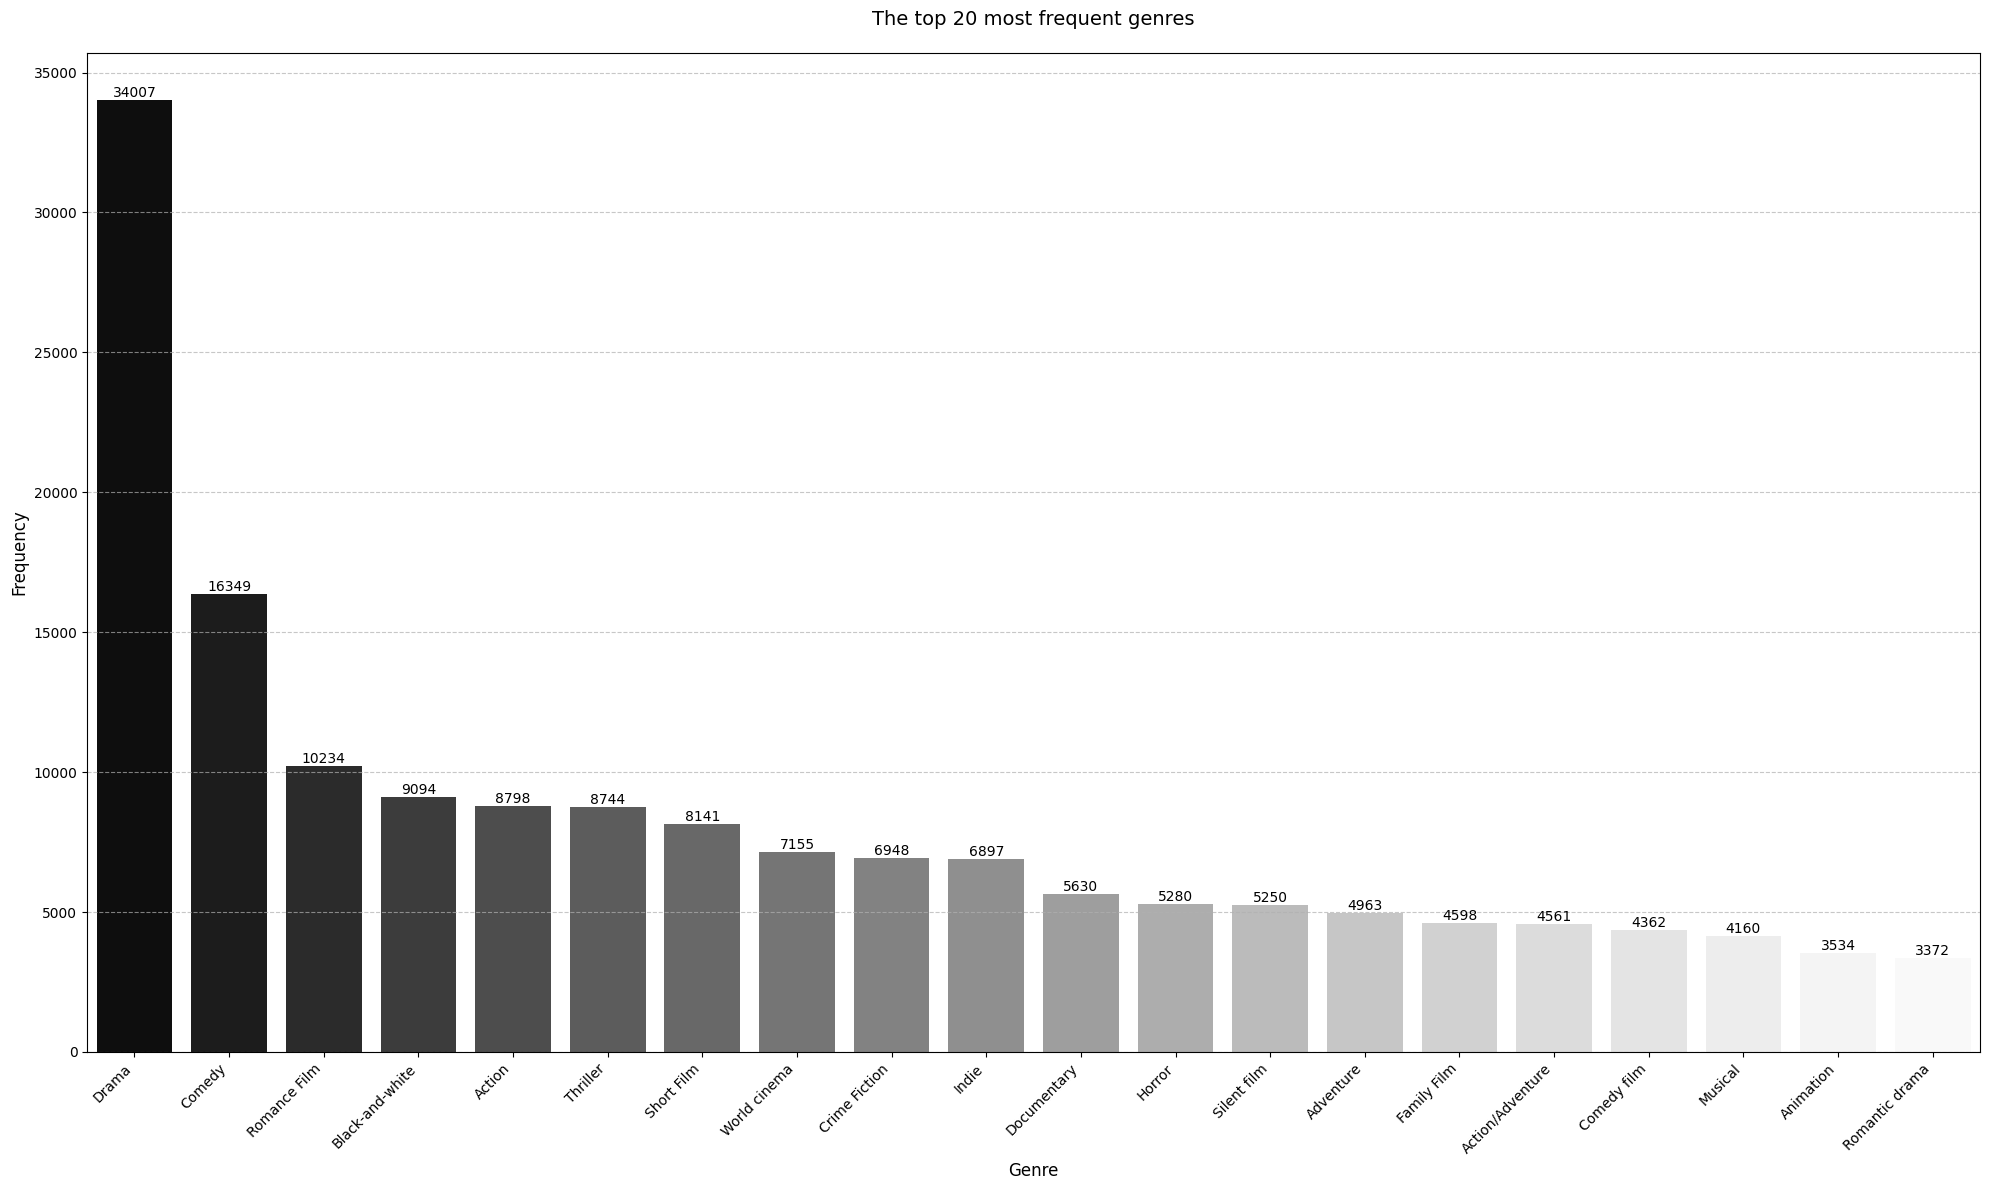


Top 10 most common genres:
    genres_list  count
          Drama  34007
         Comedy  16349
   Romance Film  10234
Black-and-white   9094
         Action   8798
       Thriller   8744
     Short Film   8141
   World cinema   7155
  Crime Fiction   6948
          Indie   6897


In [5]:
plot_popular_genres(df_movies)

## Death

In [6]:
death_rate_per_movie = df_characters.groupby('wikipedia_movie_id')['died'].mean()
print(death_rate_per_movie.describe())

count    39406.000000
mean         0.173448
std          0.309097
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max          1.000000
Name: died, dtype: float64


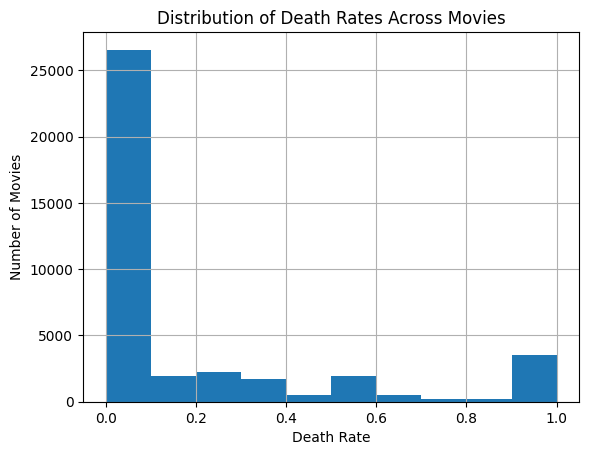

In [7]:
death_rate_per_movie.hist(bins=10)
plt.xlabel('Death Rate')
plt.ylabel('Number of Movies')
plt.title('Distribution of Death Rates Across Movies')
plt.show()

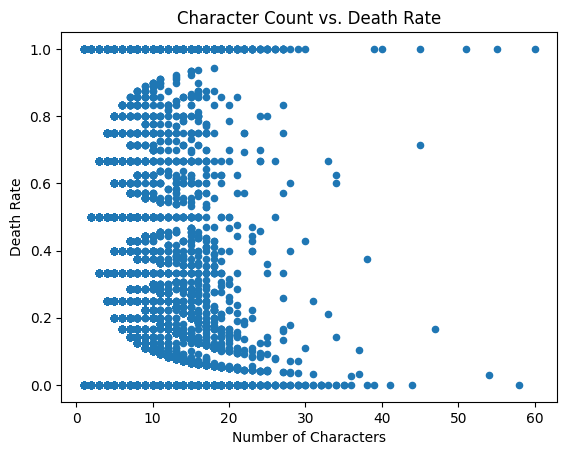

In [8]:
scatter_data = df_characters.groupby('wikipedia_movie_id').agg({'name': 'count', 'died': 'mean'})
scatter_data.plot.scatter(x='name', y='died')
plt.xlabel('Number of Characters')
plt.ylabel('Death Rate')
plt.title('Character Count vs. Death Rate')
plt.show()

## Tropes

In [10]:
# example of character trope
print('Example of character trope:')

for column in df_tropes.columns:
    print(f'- {column}: {df_tropes[column].iloc[0]}')

Example of character trope:
- name: Chosen One
- description: A character destined for greatness, often with a unique power or lineage.
- id: CHOSEN_ONE


In [10]:
df_characters.head()

wikipedia_movie_id                  name            trope_id  died  \
0             5369062            Dr. Kobras       EVIL_OVERLORD   1.0   
1             5369062           Jane Dobson  DAMSEL_IN_DISTRESS   0.0   
2             5369062  Tony Farms (Pumaman)      RELUCTANT_HERO   0.0   
3             5369062               Vadinho              MENTOR   0.0   
4            33663027       Kenny/Sivakumar         TRAGIC_HERO   1.0   

  actor_dob actor_gender  actor_height actor_ethnicity actor_name  \
0       NaN          NaN           NaN             NaN        NaN   
1       NaN          NaN           NaN             NaN        NaN   
2       NaN          NaN           NaN             NaN        NaN   
3       NaN          NaN           NaN             NaN        NaN   
4       NaN          NaN           NaN             NaN        NaN   

   actor_age_at_release  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In total we have 190198 characters whose trope we identified while also knowing if they died in the movie.
Tropes classified into 99 tropes (1 of them being the "NO TROPE" trope).


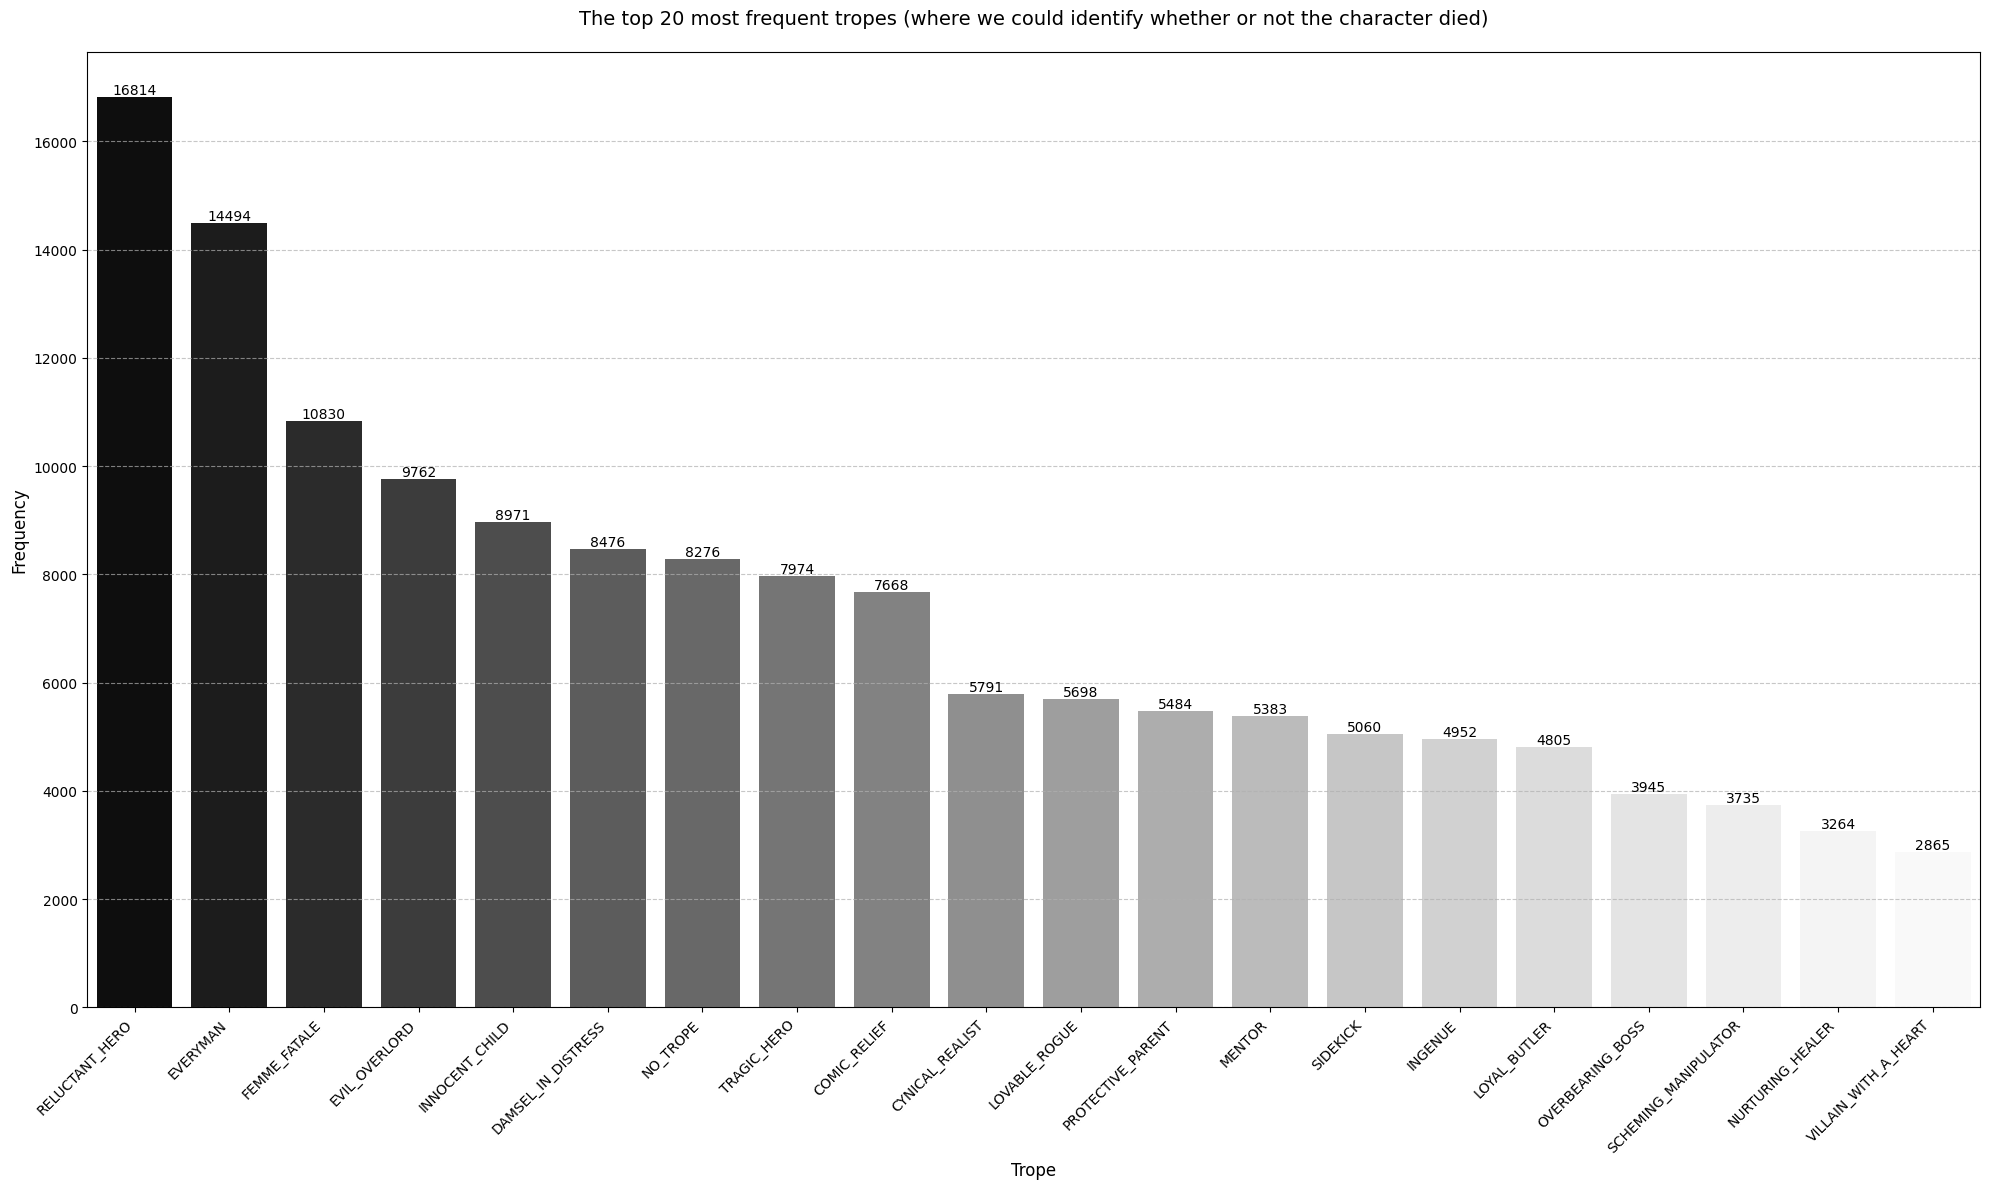


Top 10 most common tropes:
          trope_id  count
    RELUCTANT_HERO  16814
          EVERYMAN  14494
      FEMME_FATALE  10830
     EVIL_OVERLORD   9762
    INNOCENT_CHILD   8971
DAMSEL_IN_DISTRESS   8476
          NO_TROPE   8276
       TRAGIC_HERO   7974
      COMIC_RELIEF   7668
   CYNICAL_REALIST   5791


In [11]:
plot_popular_tropes(df_characters, df_tropes)

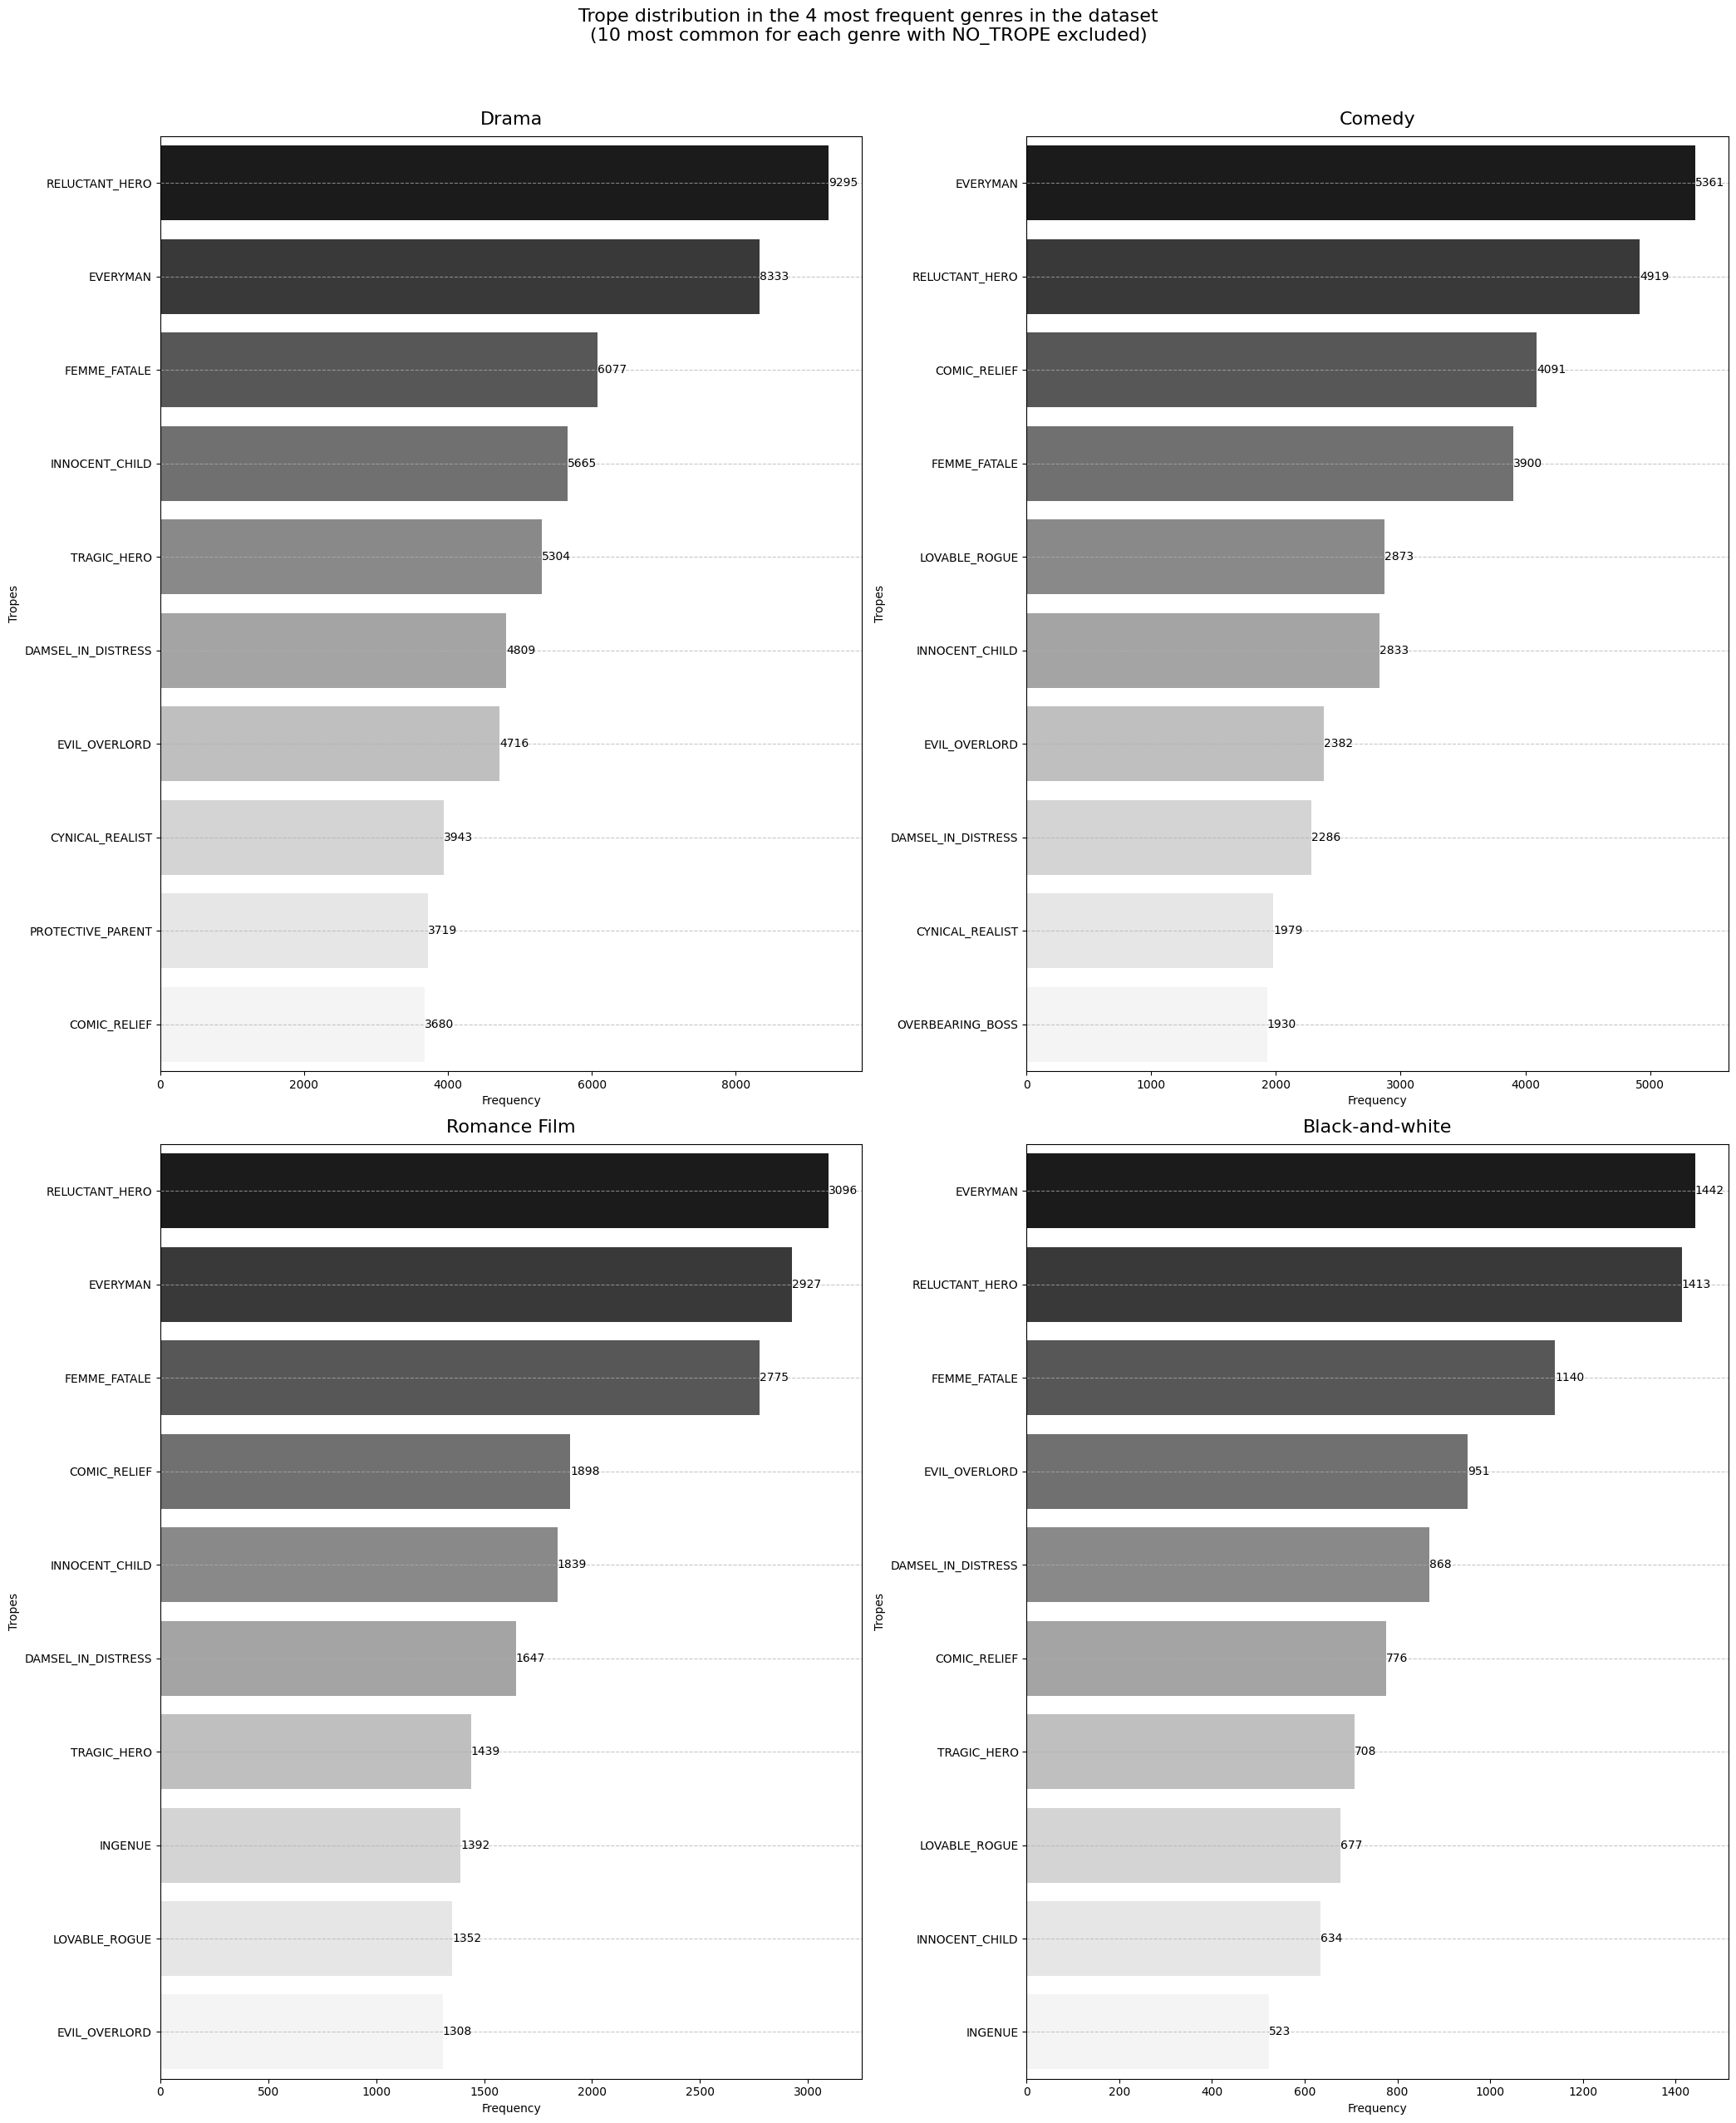


Top 10 most common tropes in Drama:
          trope_id  count
    RELUCTANT_HERO   9295
          EVERYMAN   8333
      FEMME_FATALE   6077
    INNOCENT_CHILD   5665
       TRAGIC_HERO   5304
DAMSEL_IN_DISTRESS   4809
     EVIL_OVERLORD   4716
   CYNICAL_REALIST   3943
 PROTECTIVE_PARENT   3719
      COMIC_RELIEF   3680

Top 10 most common tropes in Comedy:
          trope_id  count
          EVERYMAN   5361
    RELUCTANT_HERO   4919
      COMIC_RELIEF   4091
      FEMME_FATALE   3900
     LOVABLE_ROGUE   2873
    INNOCENT_CHILD   2833
     EVIL_OVERLORD   2382
DAMSEL_IN_DISTRESS   2286
   CYNICAL_REALIST   1979
  OVERBEARING_BOSS   1930

Top 10 most common tropes in Romance Film:
          trope_id  count
    RELUCTANT_HERO   3096
          EVERYMAN   2927
      FEMME_FATALE   2775
      COMIC_RELIEF   1898
    INNOCENT_CHILD   1839
DAMSEL_IN_DISTRESS   1647
       TRAGIC_HERO   1439
           INGENUE   1392
     LOVABLE_ROGUE   1352
     EVIL_OVERLORD   1308

Top 10 most common tro

In [12]:
plot_popular_genres_tropes(df_movies, df_characters)

#### What are the most common genres and character tropes in movies? 
Drama emerges as the most frequent genre, followed by Comedy and Romance, which reflect their broad liking in public opinion. When looking at tropes, the Reluctant Hero and Everyman dominate across movies, emphasizing characters who embark on journeys relatable to general consumer. In genres like Comedy, tropes such as Comic Relief and Lovable Rogue bring humor and charm, while Romance frequently features the Femme Fatale, adding elements of mystery and drama.

## Death and Tropes

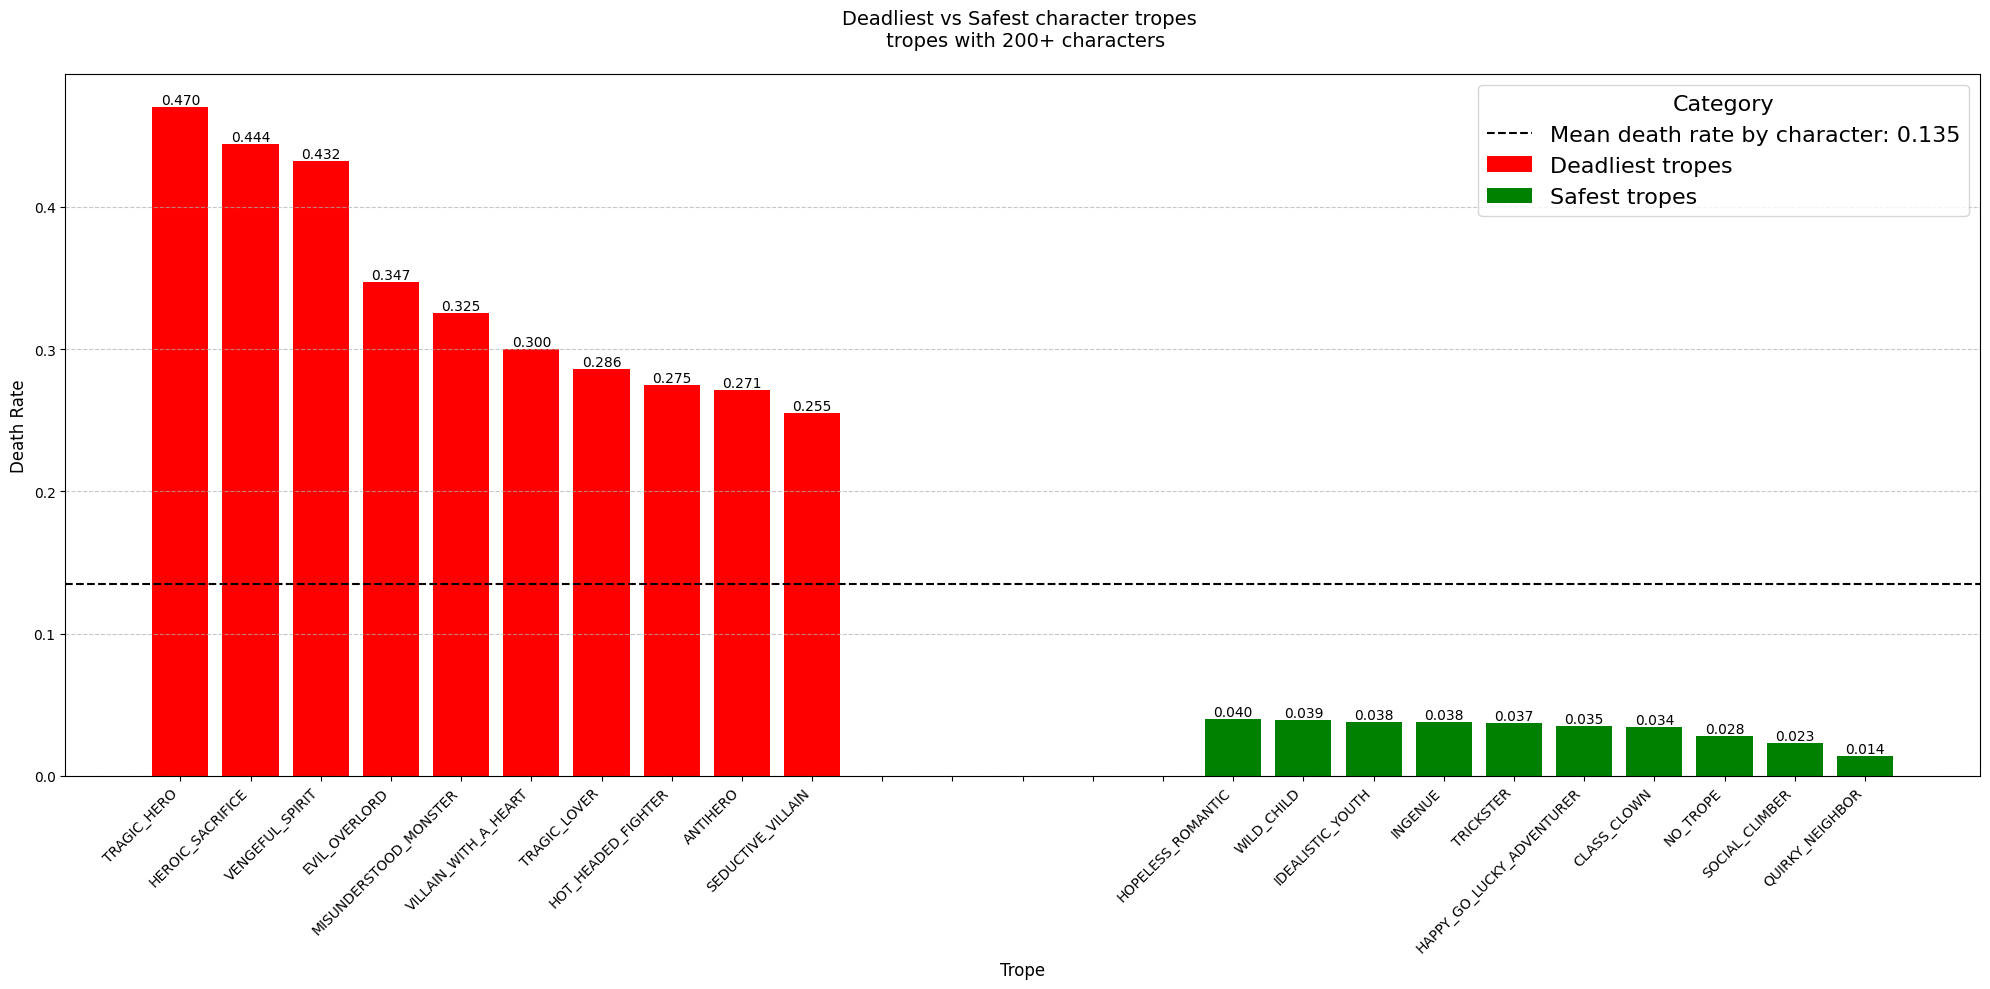


Overall mortality rate: 0.135

Top 10 deadliest character tropes:
                       total_characters  total_deaths  death_rate
trope_id                                                         
TRAGIC_HERO                        7974        3747.0       0.470
HEROIC_SACRIFICE                    385         171.0       0.444
VENGEFUL_SPIRIT                     475         205.0       0.432
EVIL_OVERLORD                      9762        3386.0       0.347
MISUNDERSTOOD_MONSTER              1822         592.0       0.325
VILLAIN_WITH_A_HEART               2865         860.0       0.300
TRAGIC_LOVER                       1662         476.0       0.286
HOT_HEADED_FIGHTER                  444         122.0       0.275
ANTIHERO                           1146         310.0       0.271
SEDUCTIVE_VILLAIN                   800         204.0       0.255

Top 10 safest character tropes:
                           total_characters  total_deaths  death_rate
trope_id                              

In [13]:
plot_tropes_death_rates(df_characters)

#### Which genres exhibit higher mortality? 

Looking at the death rates across movie genres, horror subgenres stand out with significantly higher mortality. Films like Slasher, Natural Horror, and Zombie consistently have the most deaths. Probably it’s because plots in these genres often focus on survival against deadly threats. On the other hand, easy-going genres such as Comedy of Manners or Romantic Comedy show much lower death rates, because death frequently is not a major theme of the plot.

## Genres

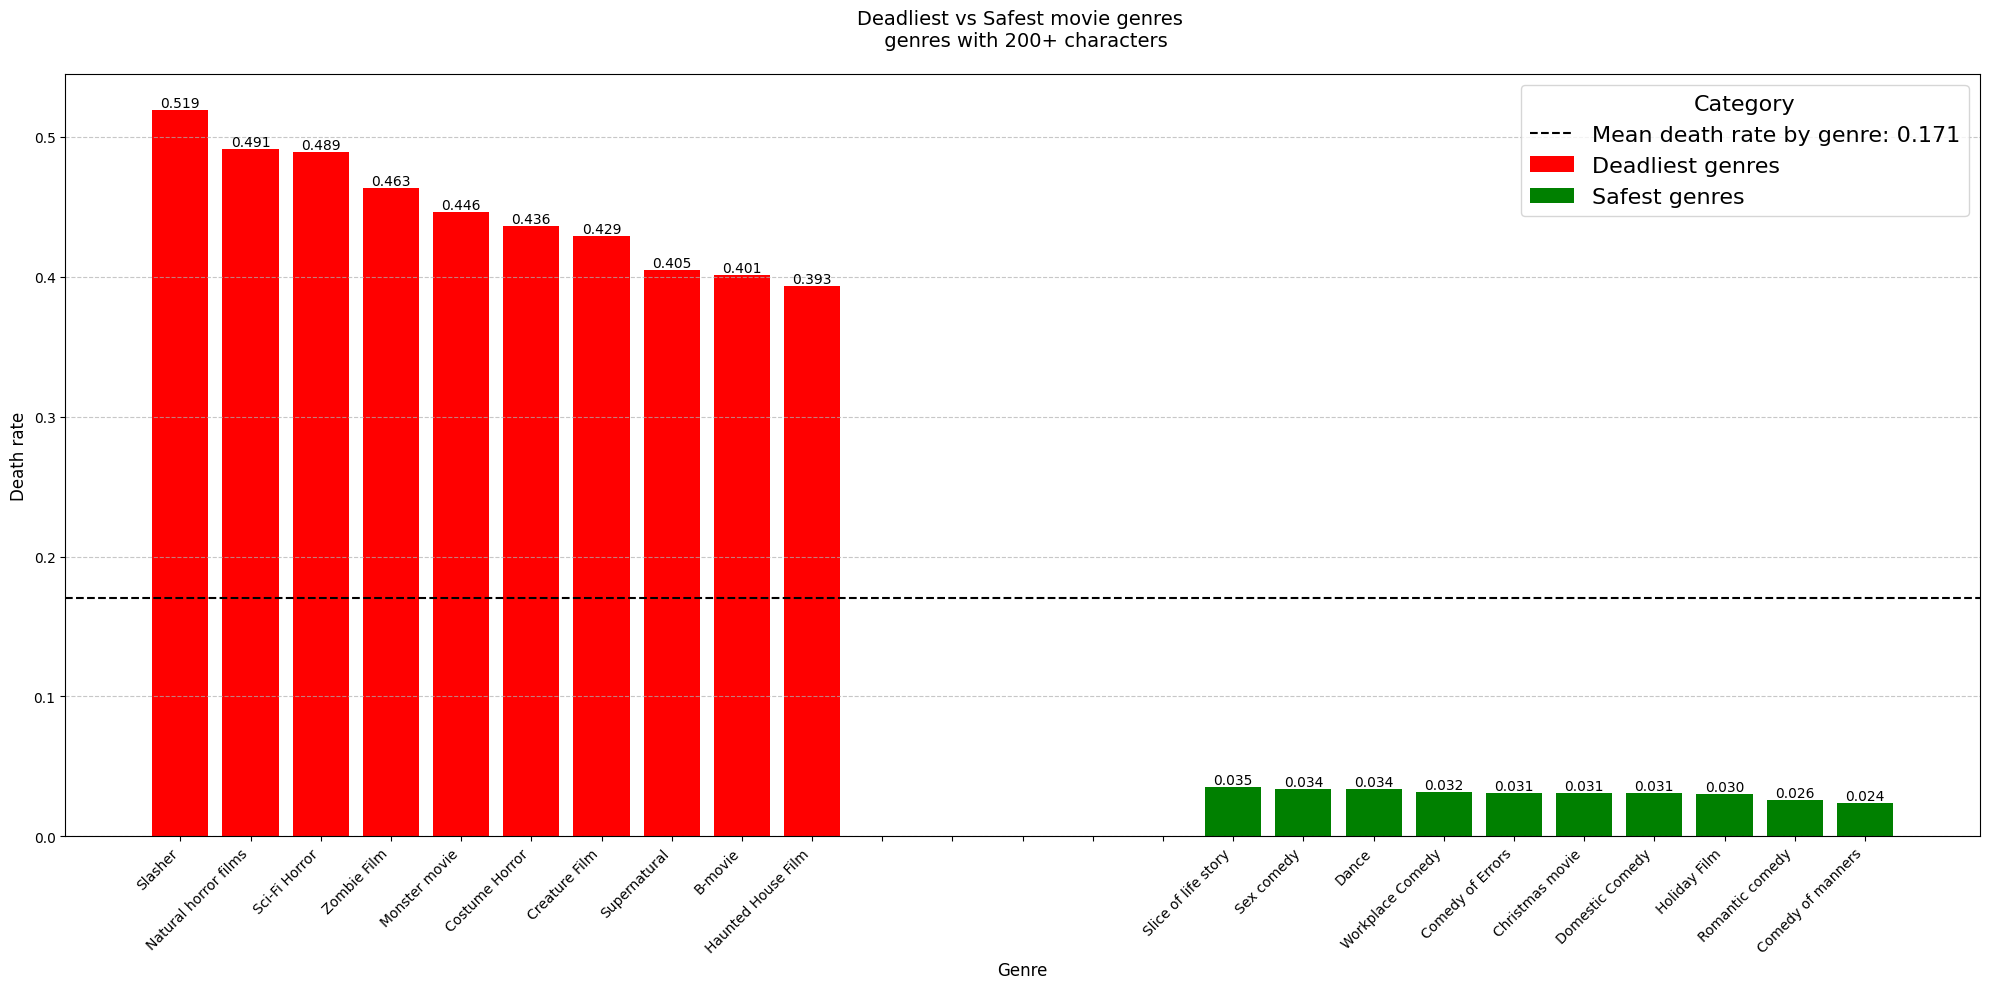


Overall mortality rate: 0.171

Top 10 deadliest genres:
                      total_characters  total_deaths  death_rate
genres_list                                                     
Slasher                           3110        1614.0       0.519
Natural horror films               648         318.0       0.491
Sci-Fi Horror                      593         290.0       0.489
Zombie Film                       1093         506.0       0.463
Monster movie                      717         320.0       0.446
Costume Horror                     250         109.0       0.436
Creature Film                     1542         661.0       0.429
Supernatural                      2808        1136.0       0.405
B-movie                           1438         577.0       0.401
Haunted House Film                 305         120.0       0.393

Top 10 safest genres:
                     total_characters  total_deaths  death_rate
genres_list                                                    
Slice of lif

In [14]:
plot_genres_death_rates(df_movies, df_characters)

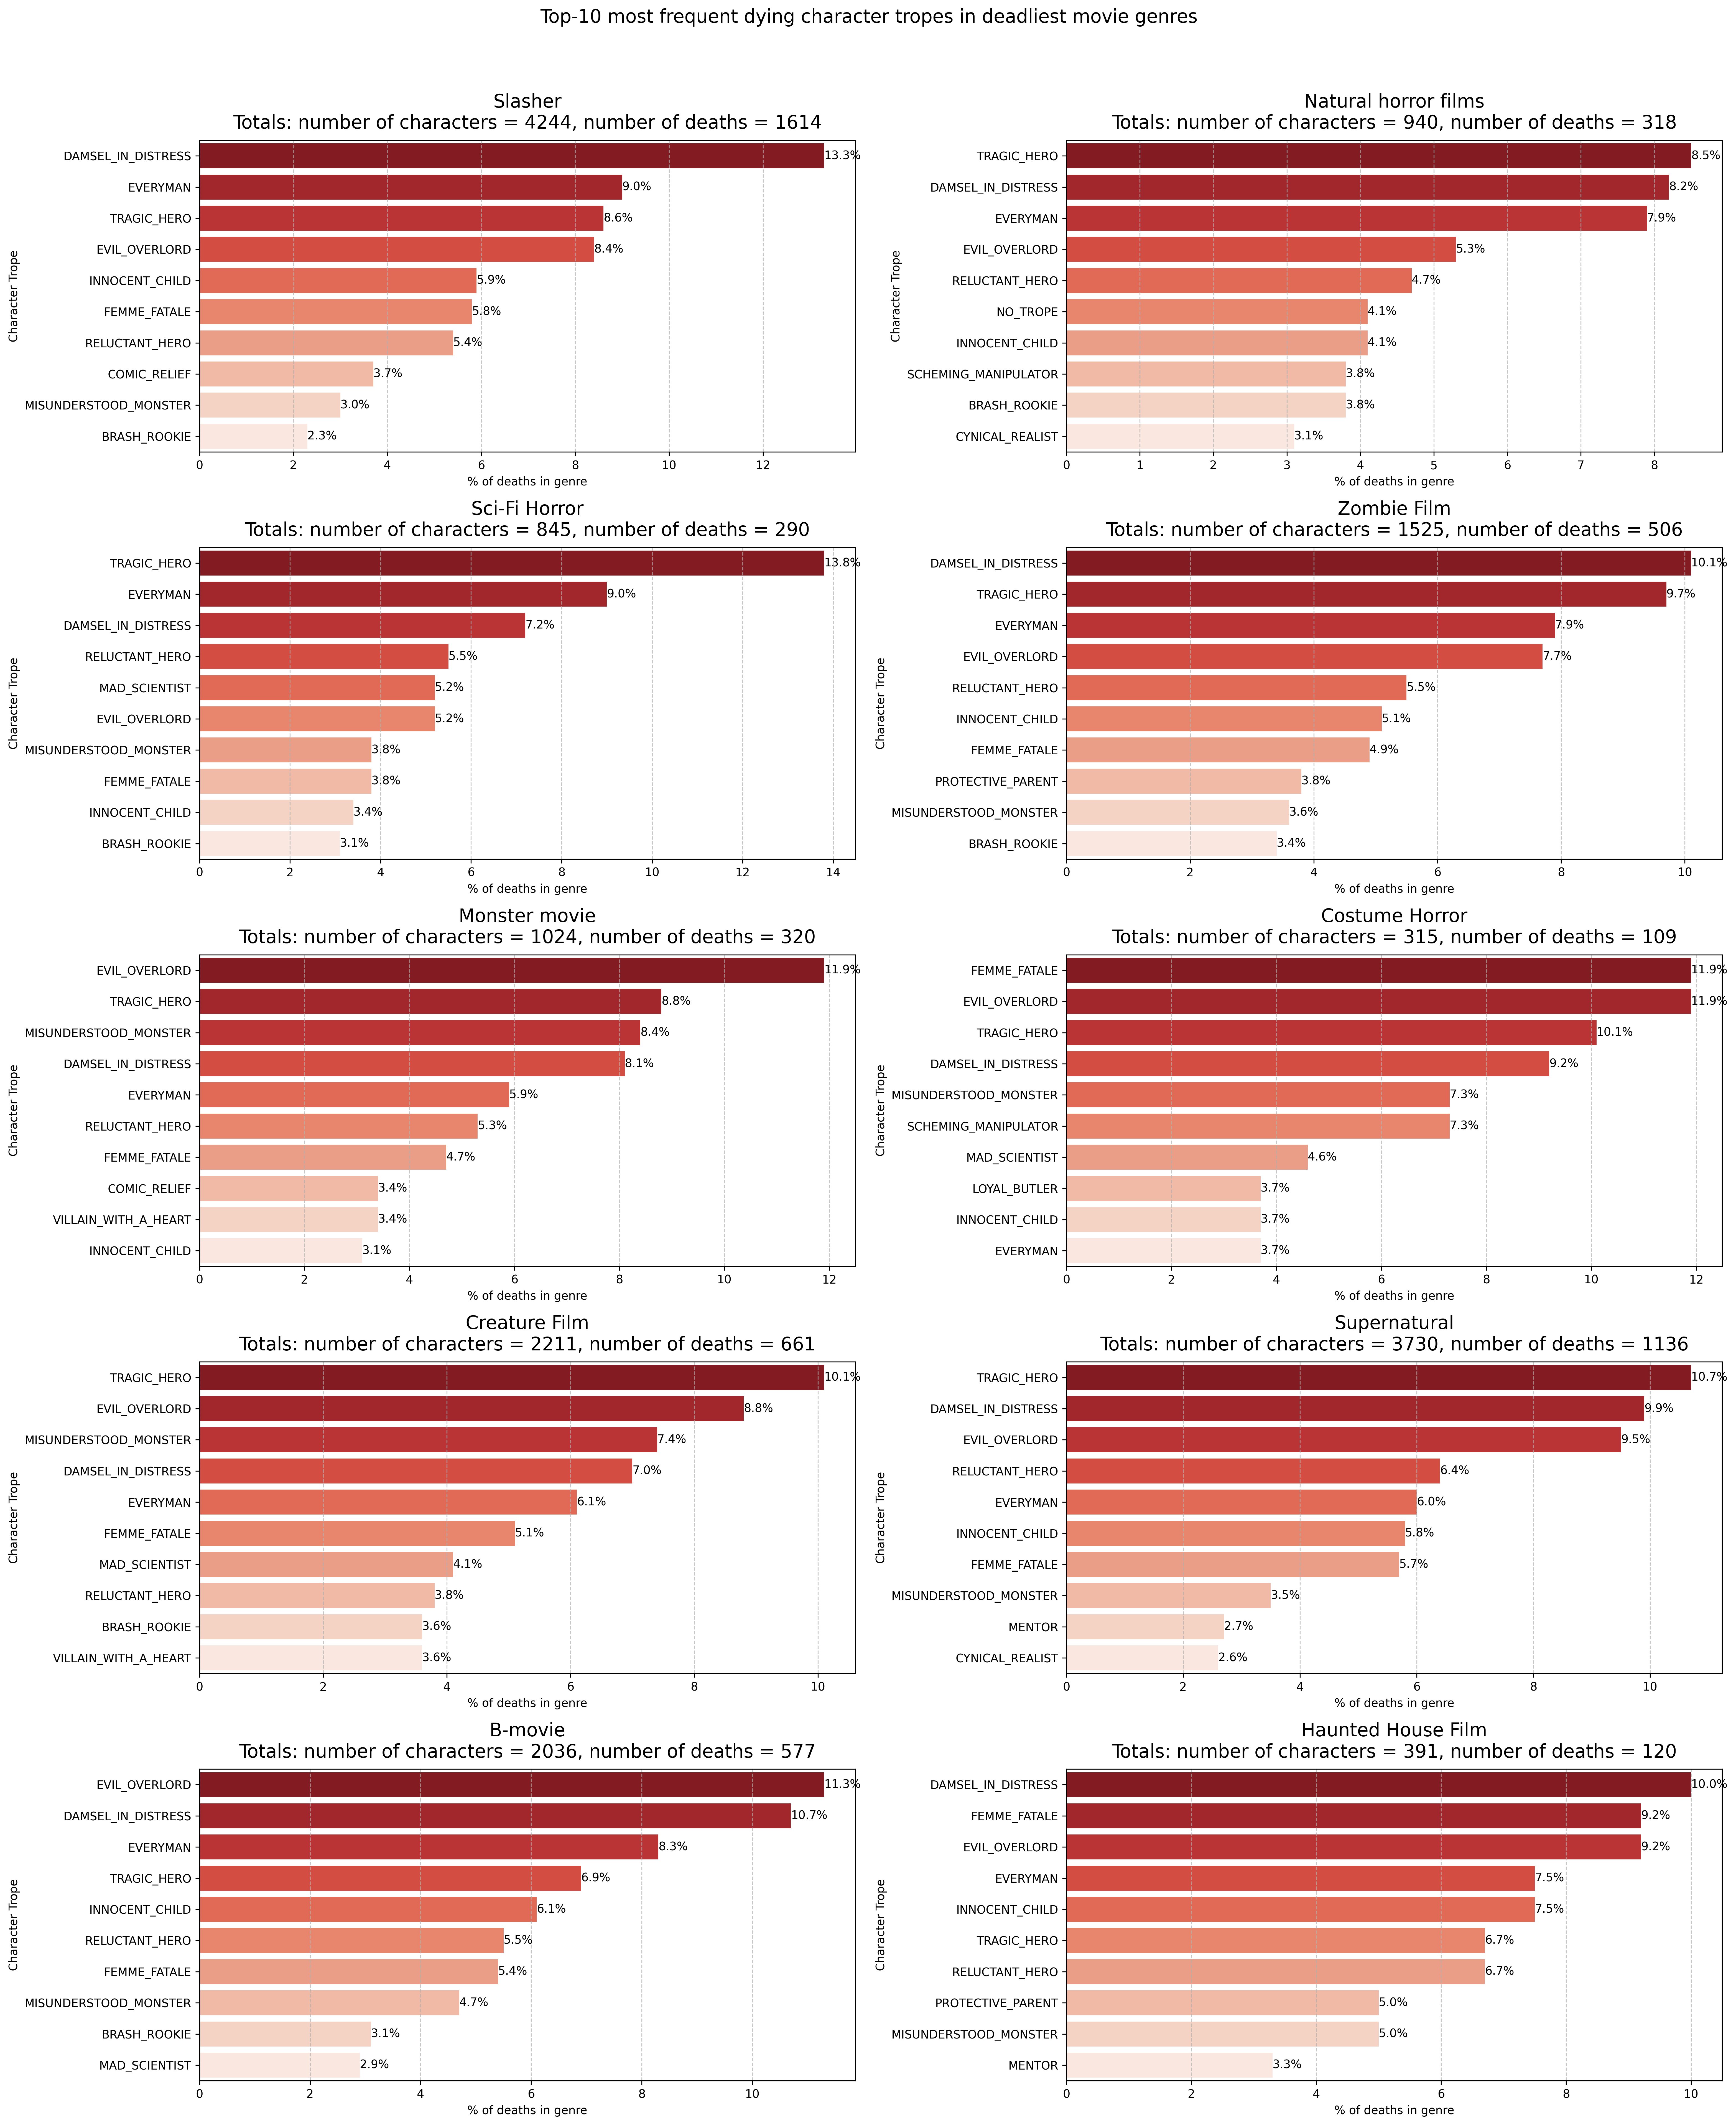


Detailed breakdown of deaths by trope in deadliest movie genres:

Slasher:
Totals: number of characters = 4244, number of deaths = 1614
                       Total characters  Number of deaths  Death rate  \
trope_id                                                                
DAMSEL_IN_DISTRESS                  337               215        63.8   
EVERYMAN                            341               145        42.5   
TRAGIC_HERO                         201               138        68.7   
EVIL_OVERLORD                       315               135        42.9   
INNOCENT_CHILD                      252                96        38.1   
FEMME_FATALE                        204                94        46.1   
RELUCTANT_HERO                      371                87        23.5   
COMIC_RELIEF                        149                60        40.3   
MISUNDERSTOOD_MONSTER               127                48        37.8   
BRASH_ROOKIE                         51                37   

In [15]:
plot_top_genres_tropes_deaths(df_movies, df_characters)

#### Are certain character types more prone to death in films? 

In the deadliest genres, certain character types, or tropes, appear more likely to die. For instance, in Slasher films, characters like the Damsel in Distress and the Tragic Hero often face grim outcomes, representing vulnerability or sacrifice. Similarly, in Zombie movies, tropes like the Protective Parent or Reluctant Hero are common among those who don’t survive, providing the emotional burst for the movie plot. Antagonists, such as the Evil Overlord, also frequently die across many genres, emphasizing their role in resolving the story's central conflict.

## Actors

In [16]:
df_actors = df_characters.dropna(subset=['actor_name'])
print(f'After filtering characters without identified actor, we kept {len(df_actors)} characters (deleted {len(df_characters) - len(df_actors)})')

df_actors.head()

After filtering characters without identified actor, we kept 133499 characters (deleted 104037)


wikipedia_movie_id                   name               trope_id  died  \
27            10731337          Johann Moritz            TRAGIC_HERO   0.0   
28              564947         Alfred Lanning                 MENTOR   1.0   
29              564947  Detective Del Spooner         RELUCTANT_HERO   0.0   
30              564947           Susan Calvin        CYNICAL_REALIST   0.0   
31              564947                  Sonny  MISUNDERSTOOD_MONSTER   0.0   

     actor_dob actor_gender  actor_height actor_ethnicity        actor_name  \
27  1915-04-21            M          1.88       /m/01g7zj     Anthony Quinn   
28  1940-01-27            M          2.01             NaN    James Cromwell   
29  1968-09-25            M          1.88         /m/0x67        Will Smith   
30  1970-04-28            F          1.77             NaN  Bridget Moynahan   
31  1971-03-16            M          1.83             NaN        Alan Tudyk   

    actor_age_at_release  
27                  51.0  
28                  64.0  
29                  35.0  
30                  34.0  
31                  33.0

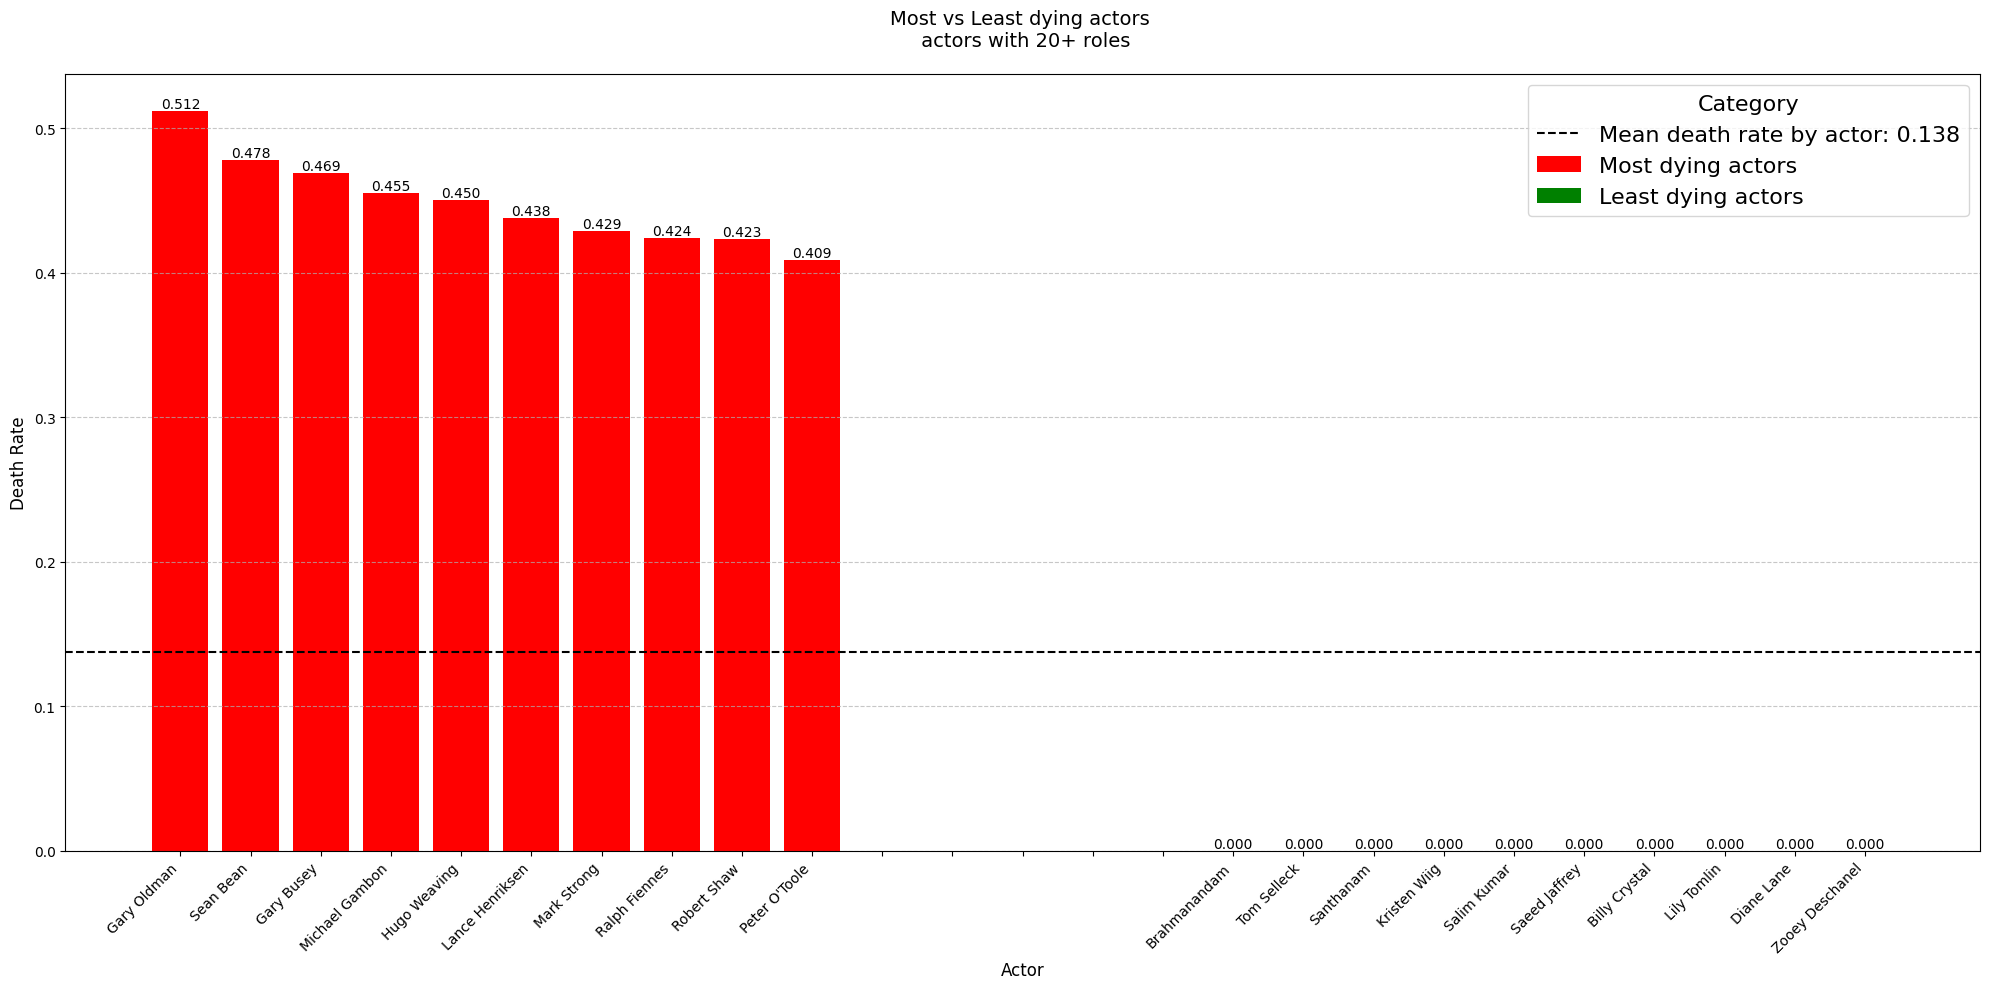


Overall mortality rate: 0.138

Top 10 most dying actors:
                 total_characters  total_deaths  death_rate
actor_name                                                 
Gary Oldman                    41          21.0       0.512
Sean Bean                      23          11.0       0.478
Gary Busey                     32          15.0       0.469
Michael Gambon                 22          10.0       0.455
Hugo Weaving                   20           9.0       0.450
Lance Henriksen                32          14.0       0.438
Mark Strong                    28          12.0       0.429
Ralph Fiennes                  33          14.0       0.424
Robert Shaw                    26          11.0       0.423
Peter O'Toole                  22           9.0       0.409

Top 10 least dying actors:
                 total_characters  total_deaths  death_rate
actor_name                                                 
Brahmanandam                   53           0.0         0.0
Tom Selleck   

In [17]:
plot_actors_death_rates(df_characters)

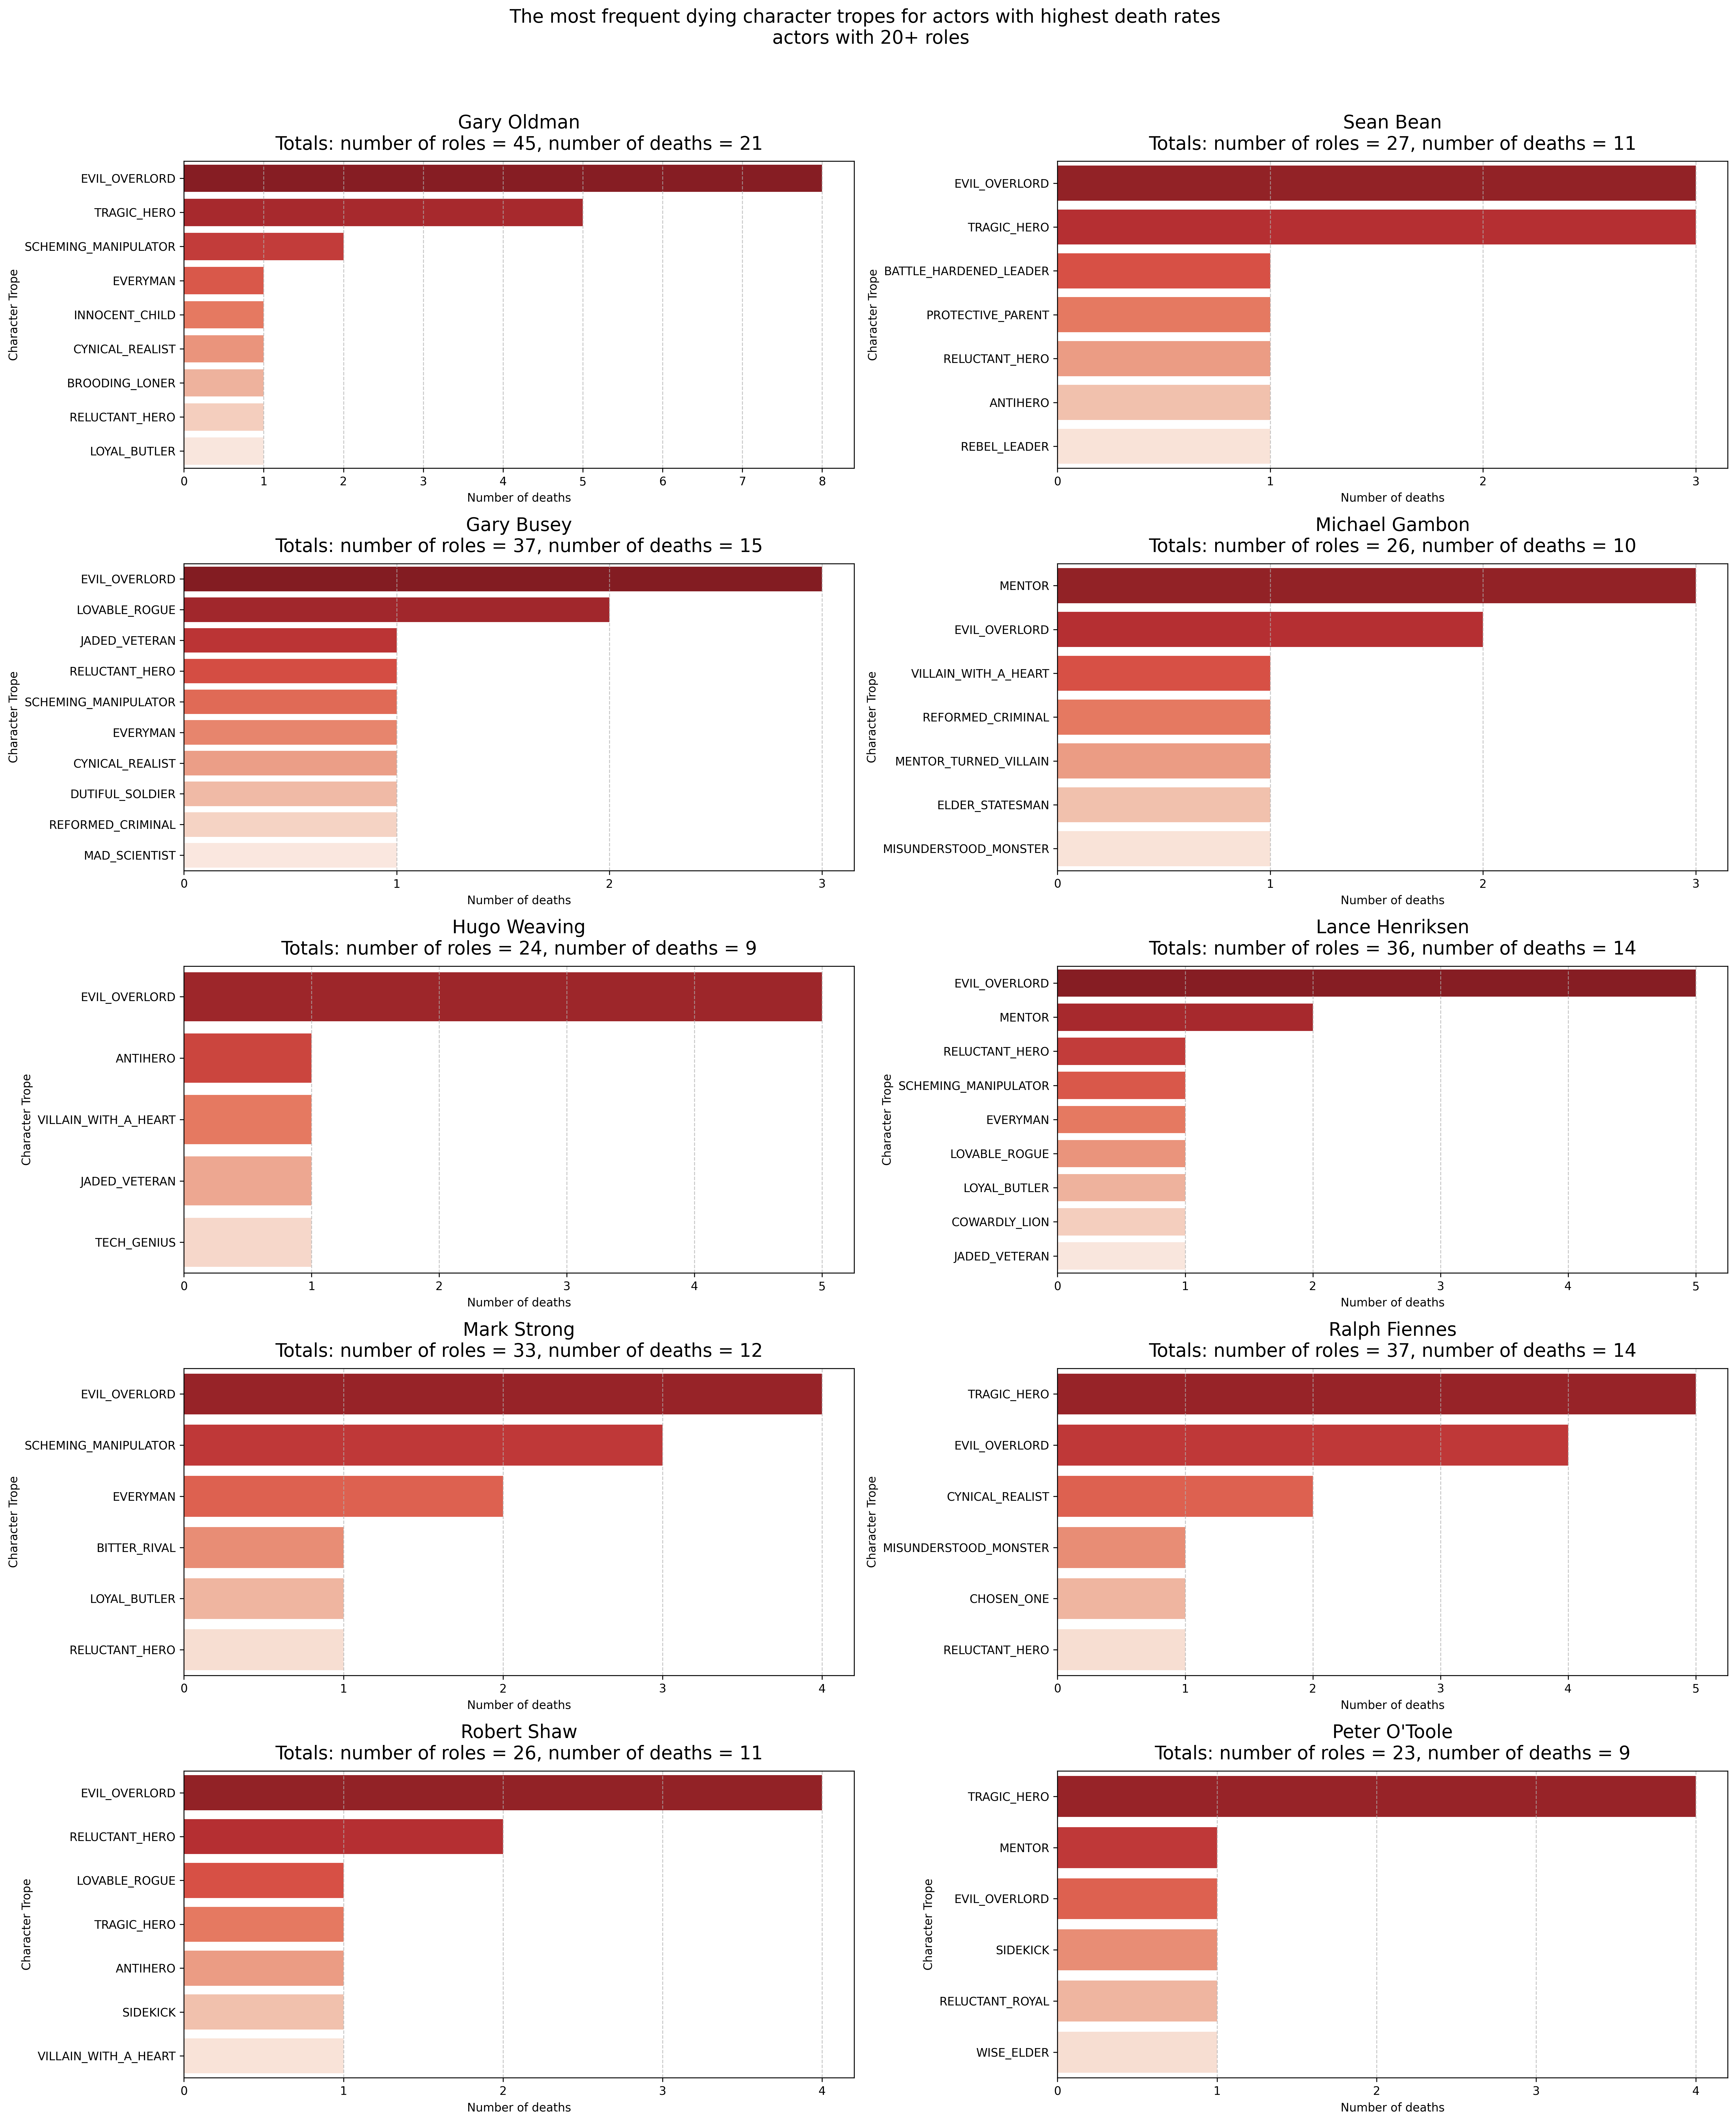


Detailed breakdown of deaths by trope for actors with highest death rates:

Gary Oldman:
Totals: number of roles = 45, number of deaths = 21
                      Total roles  Number of deaths  Death rate  \
trope_id                                                          
EVIL_OVERLORD                  10                 8        80.0   
TRAGIC_HERO                     6                 5        83.3   
SCHEMING_MANIPULATOR            3                 2        66.7   
EVERYMAN                        4                 1        25.0   
INNOCENT_CHILD                  1                 1       100.0   
CYNICAL_REALIST                 1                 1       100.0   
BROODING_LONER                  3                 1        33.3   
RELUCTANT_HERO                  4                 1        25.0   
LOYAL_BUTLER                    1                 1       100.0   

                      Percentage of actor deaths  
trope_id                                          
EVIL_OVERLORD     

In [18]:
plot_top_actors_tropes_deaths(df_characters)

#### Which actors have high on-screen death rates, and what character tropes do they portray? 

Actors like Gary Oldman and Sean Bean are known for their high on-screen death rates, often playing characters with tragic or villainous roles. Sean Bean, for example, frequently takes on the Tragic Hero or Reluctant Leader, roles that often lead to dramatic and memorable deaths. Gary Oldman, on the other hand, is often cast as the Evil Overlord, which suits his reputation for playing complex antagonists. These actors' roles reflect how typecasting and storytelling choices influence their frequent on-screen demises.